# Monitoring model predictions using Amazon SageMaker's Model Monitor

1. [Introduction](#Introduction)
2. [Host the model with monitoring enabled](#Host-the-model-with-Model-Monitoring-data-capture-enabled)
3. [Send predictions to the model](#Send-predictions-to-the-model)
4. [Review captured predictions and responses](#View-the-data-captured-by-Model-Monitor)
5. [Clean up](#Clean-up)

## Introduction

Amazon SageMaker [Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html), a new capability of Amazon SageMaker that automatically monitors machine learning (ML) models in production, and alerts you when data quality issues appear. This notebook demonstrates how you leverage Model Monitor's data capture capability against the PyTorch based image classification workload developed in earlier labs.

More specifically, we will stand up a SageMaker endpoint to host model predictions, but this time, we will enable data capture of both requests and responses. We then generate load to make requests to the endpoint. Lastly, we explore the data that Model Monitor has captured for us in S3. 

## Setup

In [107]:
bucket = sess.default_bucket() # or use your own custom bucket name
prefix = 'DEMO-PYT-image-classification-birds'
training_job_name = 'pyt-ic-2020-03-02-17-28-52-529'#'<enter your training job name here>'  ### Replace this with your job name from the previous lab
s3_capture_upload_path = f's3://{bucket}/{prefix}/endpoint-data-capture/' # 'FILL-IN-HERE-YOUR-S3-BUCKET-PREFIX-HERE' #example: s3://bucket-name/path/to/endpoint-data-capture/
print(s3_capture_upload_path)
##### 
## IMPORTANT
##
## Please make sure to add the "s3:PutObject" permission to the "role' you provided in the SageMaker Model 
## behind this Endpoint. Otherwise, Endpoint data capture will not work.
## 
##### 

s3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/endpoint-data-capture/


In [108]:
#!pip install sagemaker # workaround for Studio preview issue

To host the image classification model on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. Here we will use the execution role the current notebook instance was given when it was created.  This role has necessary permissions, including access to your data in S3.

In [109]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::355151823911:role/service-role/AmazonSageMaker-ExecutionRole-20180515T132694


We also need to identify the S3 bucket that you want to use for capturing prediction data. In this notebook, we use a default bucket for use with SageMaker in your account. Alternatively, you could use whatever bucket you would like.  We use an object prefix to help organize the bucket content.

## Create train/val/test dataframes from our dataset

In [110]:
import pandas as pd
import boto3
import json
import pandas as pd

runtime = boto3.client(service_name='runtime.sagemaker')

import matplotlib.pyplot as plt
%matplotlib inline

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
SAMPLE_ONLY  = True
CLASSES = [13, 17, 35, 36]#, 47, 68, 73, 75, 87, 95, 120, 179, 192]
#CLASSES = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  11,  12,  13,
#           17, 35, 36, 47, 68, 73, 75, 87, 95, 120, 179, 192, 193]

# Otherwise, you can use the full set of species
if not SAMPLE_ONLY:
    CLASSES = []
    for c in range(200):
        CLASSES += [c + 1]
    prefix = prefix + '-full'

#BASE_DIR   = 'CUB_200_2011/'
BASE_DIR   = 'CUB_MINI/'

IMAGES_DIR = BASE_DIR + 'images/'
CLASSES_FILE = BASE_DIR + 'classes.txt'

EXCLUDE_IMAGE_LIST = ['087.Mallard/Mallard_0130_76836.jpg']

SPLIT_RATIOS = (0.6, 0.2, 0.2)

CLASS_COLS   = ['class_number','class_id']

JOB_PREFIX   = 'pyt-ic'

## Prepare the data channels for Amazon SageMaker
Here we will populate the local data channels with folders containing the original JPG images organized by class folders. We will use these images to generate a set of prediction requests to the endpoint.

In [111]:
classes_df = pd.read_csv(CLASSES_FILE, sep=' ', names=CLASS_COLS, header=None)
criteria = classes_df['class_number'].isin(CLASSES)
classes_df = classes_df[criteria]

class_name_list = sorted(classes_df['class_id'].unique().tolist())
print(class_name_list)

['013.Bobolink', '017.Cardinal', '035.Purple_Finch', '036.Northern_Flicker']


In [112]:
from utils import split
train_df, val_df, test_df = split.get_train_val_dataframes(BASE_DIR, CLASSES, EXCLUDE_IMAGE_LIST, SPLIT_RATIOS)

Using 237 images from 4 classes
num images total: 11788

num train: 142
num val: 47
num test: 48


In [113]:
CHANNEL_FOLDER = 'data'

### Populate local data channels
Here we populate the local channel folders, and we handle re-populating in case we have already run through this notebook with a different subset of bird species. We'll use these images for testing the model you created earlier. You can skip these cells if you are re-running this notebook after already having populated these folders. 

In [8]:
import os
cwd = os.getcwd()

In [9]:
def copy_files_for_channel(df, channel_name, verbose=False):
    print('\nCopying files for {} images in channel: {}...'.format(df.shape[0], channel_name))
    for i in range(df.shape[0]):
        target_fname = df.iloc[i]['image_file_name']
        if verbose:
            print(target_fname)
        !cp $cwd/$IMAGES_DIR/$target_fname $cwd/$CHANNEL_FOLDER/$channel_name/$target_fname

In [10]:
if os.path.exists(CHANNEL_FOLDER):
    print('About to remove {}/{}'.format(cwd, CHANNEL_FOLDER))
    perform_delete = input('Are you sure you want to remove it and start fresh (yes/no)?')
    if perform_delete == 'yes':
        for ch in ['train', 'test', 'validation']:
            !rm -i -rf $CHANNEL_FOLDER/$ch/*
            !rm -i -rf $CHANNEL_FOLDER/$ch
            !mkdir  $CHANNEL_FOLDER/$ch

        for c in class_name_list:
            !mkdir $CHANNEL_FOLDER/train/$c
            !mkdir $CHANNEL_FOLDER/validation/$c
            !mkdir $CHANNEL_FOLDER/test/$c
            
        copy_files_for_channel(val_df,   'validation')
        copy_files_for_channel(test_df,  'test')
        copy_files_for_channel(train_df, 'train')
else:
    print('Channel folder does not yet exist. Creating it and subfolders for each channel.')
    os.mkdir(CHANNEL_FOLDER)
    os.mkdir(CHANNEL_FOLDER + '/validation')
    os.mkdir(CHANNEL_FOLDER + '/test')
    os.mkdir(CHANNEL_FOLDER + '/train')
    for c in class_name_list:
        os.mkdir('{}/{}/{}'.format(CHANNEL_FOLDER, 'validation', c))
        os.mkdir('{}/{}/{}'.format(CHANNEL_FOLDER, 'test', c))
        os.mkdir('{}/{}/{}'.format(CHANNEL_FOLDER, 'train', c))
    
    copy_files_for_channel(val_df,   'validation')
    copy_files_for_channel(test_df,  'test')
    copy_files_for_channel(train_df, 'train')

About to remove /root/sagemaker-workshop/pytorch-workshop/data


Are you sure you want to remove it and start fresh (yes/no)? yes



Copying files for 47 images in channel: validation...

Copying files for 48 images in channel: test...

Copying files for 142 images in channel: train...


## Host the model with Model Monitoring data capture enabled

Since our model is already trained, we can simply instantiate a SageMaker Estimator object based on the training job name.

In [114]:
import sagemaker
from sagemaker.pytorch import PyTorch
import logging

FRAMEWORK_VERSION = '1.3.1'
serve_instance_type  = 'ml.c5.4xlarge' #p3.2xlarge'

In [115]:
from sagemaker.estimator import Estimator
estimator = Estimator.attach(training_job_name)

2020-03-02 17:34:20 Starting - Preparing the instances for training
2020-03-02 17:34:20 Downloading - Downloading input data
2020-03-02 17:34:20 Training - Training image download completed. Training in progress.
2020-03-02 17:34:20 Uploading - Uploading generated training model
2020-03-02 17:34:20 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-03-02 17:32:48,640 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-03-02 17:32:48,665 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-03-02 17:32:48,666 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-03-02 17:32:48,931 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-03-02 17:32:48,932 sagemaker-containers INFO     Generating setup.cfg
2020-03-02 17:32:48,

Feel free to change parameters as you would like - adjust sampling percentage, and whether to include requests, responses, or both. 
Learn more from our [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html).

In [116]:
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker import RealTimePredictor
from sagemaker import session
import boto3

data_capture_config = DataCaptureConfig(
                        enable_capture = True,
                        sampling_percentage=100,
                        destination_s3_uri=s3_capture_upload_path,
                        kms_key_id=None,
                        capture_options=['RESPONSE', 'REQUEST'])

In [117]:
predictor = estimator.deploy(initial_instance_count=1, 
                             instance_type=serve_instance_type,
                             data_capture_config=data_capture_config)

Using already existing model: pyt-ic-2020-03-02-17-28-52-529


-------------!

## Send predictions to the model

In [ ]:
# If using an endpoint that was already in service, you can establish a predictor object using the following code.
#
#from sagemaker import RealTimePredictor
#predictor = RealTimePredictor(endpoint='tensorflow-inference-2020-02-14-12-36-15-896') #<put-endpoint-name-here>')

### Predicting using the SageMaker PyTorch endpoint

In [119]:
from PIL import Image
import io, time
import numpy as np
from sagemaker.predictor import json_serializer, json_deserializer

def predict_bird_from_file(fn, verbose=True):
    pil_img = Image.open(fn)
    buf = io.BytesIO()
    pil_img.save(buf, format='JPEG')
    byte_im = buf.getvalue()

    start_time = time.time()
    
    predictor.content_type = 'application/x-image'
    predictor.serializer   = None
    predictor.deserializer = json_deserializer
    
    result = predictor.predict(byte_im)
    
    if verbose:
        print('...took {:.2f} seconds'.format(time.time() - start_time))
        predicted_class_idx = np.argmax(result)
        predicted_class = class_name_list[predicted_class_idx]
        confidence = result[predicted_class_idx]
        display(Image.open(fn).resize((224, 224)))
        print(f'Class: {predicted_class}, confidence: {confidence:.2f}')
    del pil_img
    return result

In [120]:
#predict_bird_from_file('northern-cardinal-1.jpg')

In [121]:
# Iterate through entire dataframe, tracking predictions and accuracy. For mistakes, show the image, 
# and the predicted and actual classes to help understand
# where the model may need additional tuning.

def test_image_df(df, verbose=True):
    print('Testing {} images'.format(df.shape[0]))
    num_errors = 0
    preds = []
    acts  = []
    for i in range(df.shape[0]):
        fname = df.iloc[i]['image_file_name']
        act   = int(df.iloc[i]['class_id']) - 1
        acts.append(act)
        prediction_list = predict_bird_from_file(IMAGES_DIR + '/' + fname, verbose=False)
        pred = np.argmax(prediction_list)
        conf = prediction_list[pred]
        preds.append(pred)
        if (pred != act):
            num_errors += 1
            print('ERROR on image index {} -- Pred: {} {:.2f}, Actual: {}'.format(i, 
                                                                   class_name_list[pred], conf, 
                                                                   class_name_list[act]))
            if verbose:
                print(f'    {prediction_list}')
                display(Image.open(IMAGES_DIR + '/' + fname))
    return num_errors, preds, acts

In [122]:
import time

def hit_endpoint_with_load(rough_num_predictions):
    num_val_images = val_df.shape[0]
    times_through_dataset = round(rough_num_predictions / num_val_images)
    print(f'running through val dataset {times_through_dataset} times...\n')
    start_time = time.time()
    for i in range(times_through_dataset):
        num_errors, preds, acts = test_image_df(val_df, verbose=False)
        print('\nAccuracy: {:.2f}, {}/{}\n'.format(1 - (num_errors/num_val_images), 
                                                   num_val_images - num_errors, num_val_images))
    num_predictions = times_through_dataset * num_val_images
    elapsed_wall_time = time.time() - start_time
    print(f'\nTook {elapsed_wall_time} seconds to predict on {num_predictions} images')
    print('{:.1f} ms/image.\n'.format(elapsed_wall_time / num_predictions * 1000))

Here we loop through the validation images enough times to generate the number of prediction requests you want to send to the endpoint.

In [123]:
%%time
hit_endpoint_with_load(100)

running through val dataset 2 times...

Testing 47 images

Accuracy: 1.00, 47/47

Testing 47 images

Accuracy: 1.00, 47/47


Took 17.279478311538696 seconds to predict on 94 images
183.8 ms/image.

CPU times: user 1.92 s, sys: 27.9 ms, total: 1.95 s
Wall time: 17.3 s


## View the data captured by Model Monitor

In [130]:
from sagemaker.s3 import S3Downloader

# Get a list of S3 URIs
capture_file_list = S3Downloader.list(s3_capture_upload_path)
print(f'Found {len(capture_file_list)} data capture files\n{capture_file_list}')

Found 3 data capture files
['s3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/endpoint-data-capture/pyt-ic-2020-03-02-17-28-52-529/AllTraffic/2020/03/02/21/14-42-833-57bd2ff2-f53d-4f33-9440-26d9c8f735b9.jsonl', 's3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/endpoint-data-capture/pyt-ic-2020-03-02-17-28-52-529/AllTraffic/2020/03/02/21/34-02-151-f3ae1000-e2b2-48fb-a813-5646719a5fd7.jsonl', 's3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/endpoint-data-capture/pyt-ic-2020-03-02-17-28-52-529/AllTraffic/2020/03/04/17/34-52-445-9305eddd-46b7-4e35-be05-5dfbc7e1d1e8.jsonl']


Download the most recent json lines file, and examine what was captured.

In [132]:
captured_data_as_str = S3Downloader.read_file(capture_file_list[-1])

In [133]:
!pip install jsonlines

You should consider upgrading via the 'pip install --upgrade pip' command.


In [135]:
import jsonlines
import io
import base64

Read the first two requests that were captured.

In [69]:
fp = io.BytesIO(captured_data_as_str.encode('utf-8'))
reader = jsonlines.Reader(fp)
first = reader.read()
second = reader.read()
reader.close()
fp.close()

Display the image that was sent. Model Monitor captures it with base64 encoding, so here we turn that back into an image and display it.

In [136]:
img_bytes = base64.decodebytes(second['captureData']['endpointInput']['data'].encode('utf-8'))

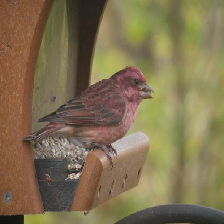

In [137]:
stream = io.BytesIO(img_bytes)
img = Image.open(stream)
img = img.resize((224, 224))
display(img)

Display the prediction that was made by the model at that time for that image. Here we show the confidence levels provided for each class.

In [139]:
predictions_str = second['captureData']['endpointOutput']['data']
predictions = json.loads(predictions_str)
predictions

[0.010412400588393211,
 0.04694483429193497,
 0.9185089468955994,
 0.024133814498782158]

Here we show the name of the class with the highest confidence level.

In [140]:
class_name_list[np.argmax(predictions)]

'035.Purple_Finch'

## Clean up
Finally, and importantly, to avoid being billed for an idle endpoint, here we delete the SageMaker endpoint.

In [71]:
predictor.delete_endpoint()

## Possible extensions for model monitoring of computer vision workloads
- Replay mechanism to test new versions of models to compare results from PROD with old model
- Feed Amazon SageMaker A2I to get a human in the loop for the set of predictions that fell below an acceptable confidence level
- Feed Amazon SageMaker Ground Truth samples of prod input images to continually keep training datasets fresh with real world samples; focus could be on crowd sourcing predictions for those images the model struggled with
- Feed dashboard of distribution of predicted classes
- Feed dashboard of confidence levels, show the p90 confidence level and alert if it falls below a threshold
- Create training dataset automatically in new s3 bucket, with a folder for each class, and filenames with confidence level and timestamp
- Create histogram of confidence levels for each class to see which classes are most in need of model improvement
- Closed loop with SageMaker Ground Truth to have near real time confusion matrix